In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# fashion mnist dataset을 통한 딥러닝 학습 실습을 정리하기 위한 공간임

* 일반적으로 로직은
* functional api 모델 생성 후 pixel 값 조정 및 type 조정
* one hot encoding 적용
* 이후 학습 검증 테스트 데이터로 나눈다
* 마지막으로 complie, 학습/예측/평가

## 데이터 전처리 수행

* 0에서 255 사이의 픽셀값을 0에서 1 사이로 변환. 이 과정을 거쳐야 성능 향상
* array type은 float32. tensorflow도 데이터를 끌어올 떄 자동적으로 float32로 바꾼다
* 전처리를 수행하기 전에 train_labels를 보면 type이 unit8로 되어 있음

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# 전처리를 수행하기 전 데이터들을 보면 type이 unit8임
print(type(train_images[0][0][0]))
print(train_images.shape)

2024-02-02 02:04:43.150136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 02:04:43.150252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 02:04:43.296083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


4422102/4422102 [==============================] - 0s 0us/step
<class 'numpy.uint8'>
(60000, 28, 28)


In [3]:
print(test_images.shape)

(10000, 28, 28)


Text(0.5, 1.0, '9')

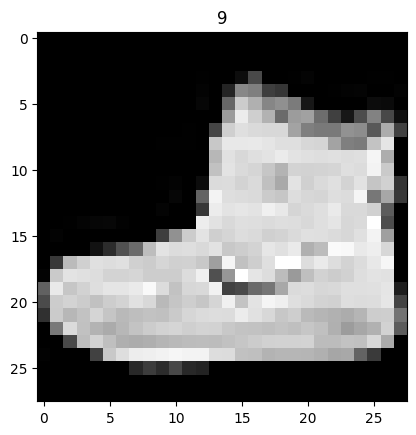

In [4]:
# fashion mnist 데이터 샘플 출력

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap='gray')
plt.title(train_labels[0])

In [5]:
# functional api를 이용한 model 생성

from tensorflow.keras.layers import  Layer, Input, Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

INPUT_SIZE = 28

def create_model():
    input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE))
    x = Flatten()(input_tensor)
    x = Dense(100, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    
    # functional api의 경우 multi input output을 지원하는데 sequentail은 불가능
    model = Model(inputs=input_tensor, outputs=output)
    
    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 81840 (319.69 KB)
Trainable params: 81840 (319.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# 데이터 전처리 함수

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 0~1 사잇값의 float32로 전처리

def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0~1 사잇값 float32로 변경하는 함수 호출 후 one hot encoding 적용

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    
    # labels 데이터를 one hot encoding
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 one hot encoding 적용
# 여기서 전처리 및 one hot encoding 과정을 거친 후 학습과 검증 데이터를 분리하면 효율적

def get_train_valid_test_split(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42):
    
    # 학습과 테스트 데이터의 전처리 후 학습이랑 검증 데이터 분리
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습과 검증 데이터 분리
    train_images, valid_images, train_oh_images, valid_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (train_images, train_oh_images), (valid_images, valid_oh_labels), (test_images, test_oh_labels)

In [7]:
# 데이터 전처리 함수를 활용한 실제 데이터 전처리

from tensorflow.keras.datasets import fashion_mnist

# fashion mnist 데이터 재 로딩 및 전처리 적용해서 학습/검증/테스트 데이터 세트 결정
# 데이터 받아오기 / 처음 받아오는 데이터 타입은 numpy.ndarray이다

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(type(train_labels))

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_split(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42)

print((tr_images.shape, tr_oh_labels.shape))  # labels를 보면 one hot encoding이 되어 있다

<class 'numpy.ndarray'>
((51000, 28, 28), (51000, 10))


# loss와 optimizer 설정을 통한 학습 수행
* loss는 categorical_crossentropy로, optimizer는 Adam으로 설정
* categorical crossentropy를 위해서 Label을 one hot encoding으로 변경(keras의 to_categorical을 통해)

In [8]:
from tensorflow.keras.optimizers import Adam

# model 생성 및 optimizer, loss, metric 적용

model = create_model()
model.summary()

# compile을 통해 loss 함수와 optimizer 설정
# one hot encoding이 되었으면 categorical, 아닌 경우 sparse categorical
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 30)                3030      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
Total params: 81840 (319.69 KB)
Trainable params: 81840 (319.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# 학습 수행의 경우 model의 fit을 통해 진행
# history를 통해 결과를 받는다. loss와 accuracy metrics를 받는다
# epoch를 통해 6만개를 batch 수만큼 쪼개서 학습하는데 이걸 epoch 횟수만큼 반복

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=20, validation_data=(val_images, val_oh_labels))

Epoch 1/20
399/399 [==============================] - 2s 4ms/step - loss: 0.5943 - accuracy: 0.7990 - val_loss: 0.4724 - val_accuracy: 0.8301
Epoch 2/20
399/399 [==============================] - 1s 3ms/step - loss: 0.4156 - accuracy: 0.8541 - val_loss: 0.3941 - val_accuracy: 0.8609
Epoch 3/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3770 - accuracy: 0.8652 - val_loss: 0.3790 - val_accuracy: 0.8664
Epoch 4/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3491 - accuracy: 0.8746 - val_loss: 0.3646 - val_accuracy: 0.8707
Epoch 5/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3302 - accuracy: 0.8803 - val_loss: 0.3618 - val_accuracy: 0.8683
Epoch 6/20
399/399 [==============================] - 1s 3ms/step - loss: 0.3133 - accuracy: 0.8864 - val_loss: 0.3472 - val_accuracy: 0.8729
Epoch 7/20
399/399 [==============================] - 1s 3ms/step - loss: 0.2996 - accuracy: 0.8924 - val_loss: 0.3476 - val_accuracy: 0.8761
Epoch 

In [10]:
history.history

{'loss': [0.5942926406860352,
  0.41556861996650696,
  0.3770429193973541,
  0.34908828139305115,
  0.33017629384994507,
  0.3132941424846649,
  0.2995648980140686,
  0.28899580240249634,
  0.27906903624534607,
  0.2660312056541443,
  0.25717249512672424,
  0.25093984603881836,
  0.24511288106441498,
  0.23891253769397736,
  0.2316754013299942,
  0.22687296569347382,
  0.2195637971162796,
  0.21247774362564087,
  0.20992568135261536,
  0.20234628021717072],
 'accuracy': [0.7990000247955322,
  0.8540784120559692,
  0.8652156591415405,
  0.8746274709701538,
  0.8802745342254639,
  0.8863529562950134,
  0.892431378364563,
  0.8956666588783264,
  0.8965686559677124,
  0.9029019474983215,
  0.9065098166465759,
  0.908294141292572,
  0.9102745056152344,
  0.9122353196144104,
  0.91460782289505,
  0.9175686240196228,
  0.9191372394561768,
  0.9220588207244873,
  0.9221176505088806,
  0.9261176586151123],
 'val_loss': [0.47237178683280945,
  0.3940671980381012,
  0.3789612054824829,
  0.364645

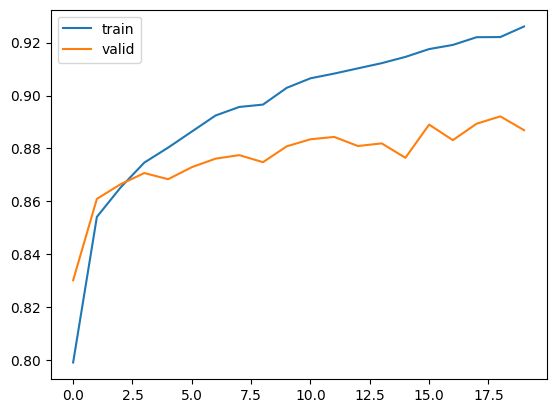

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(hisotry):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

In [12]:
# 테스트 세트로 모델 성능 검증

model.evaluate(x=test_images, y=test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 0s 3ms/step - loss: 0.3530 - accuracy: 0.8809


[0.3530273735523224, 0.8809000253677368]

## callback
* 학습 iteration을 수행할 때 특정 event가 발생하는 경우 호출하는 기능들
* 대표적으로 ModelCheckpoint(), ReduceLROnPlateau(), LearningRateScheduler(), EarlyStopping(), TensorBoard 등이 있음

### ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

* 특정 조건에 맞춰서 모델을 파일에 저장
* filepath: filepath의 경우 on epoch end에서 전달되는 epoch 값과 logs의 키로 채워진 이름 형식 옵션을 가질 수 있다. 예를 들어 filepath가 weights.{epoch:02d}-{val_loss:.2f}.hdf5d인 경우, 파일 이름에 세대 번호와 검증 손실을 넣어 모델의 체크포인트가 저장된다
* monitor: 모니터할 지표(loss 또는 평가 지표) / 대표적으론 val_loss, val_accuracy
* save_best_only: 가장 좋은 성능을 나타내는 모델만 저장할 여부
* save_weights_only: weights만 저장여부 / 성능 및 버그 감소를 위해 True로 두는 것이 좋고, save weights를 통해 저장된 값은 load weights를 통해 다시 불러오면 된다
* mode: {auto, min, max} 중 하나. monitor 지표가 감소해야 좋을 경우, 증가해야 좋은 경우를 구분해서 입력하면 된다. auto로 두면 알아서 분류해주긴 하는데 간혹 틀린 경우가 있어 직접 명시적으로 지정해주는 것이 좋다.
* periods를 길게 설정하면 save weights 같은 작업 반복 주기를 늘릴 수 있다.

In [13]:
# 현재 dir 위치
!pwd

/kaggle/working


In [14]:
# 참고로 keras의 metrics(메트릭이라고 부르기도 함)은 평가지표를 의미한다

from tensorflow.keras.callbacks import ModelCheckpoint

model = create_model()
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

mcp_ob = ModelCheckpoint(filepath='/kaggle/working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
                        save_best_only=True, save_weights_only=True, mode='min', periods=3, verbose=1)
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=10, validation_data=(val_images, val_oh_labels),
                   callbacks=[mcp_ob])

Epoch 1/10
384/399 [===========================>..] - ETA: 0s - loss: 0.5508 - accuracy: 0.7993
Epoch 1: val_loss improved from inf to 0.48458, saving model to /kaggle/working/weights.01-0.48.hdf5
399/399 [==============================] - 2s 4ms/step - loss: 0.5465 - accuracy: 0.8009 - val_loss: 0.4846 - val_accuracy: 0.8158
Epoch 2/10
384/399 [===========================>..] - ETA: 0s - loss: 0.4087 - accuracy: 0.8516
Epoch 2: val_loss improved from 0.48458 to 0.40623, saving model to /kaggle/working/weights.02-0.41.hdf5
399/399 [==============================] - 1s 3ms/step - loss: 0.4078 - accuracy: 0.8517 - val_loss: 0.4062 - val_accuracy: 0.8499
Epoch 3/10
387/399 [============================>.] - ETA: 0s - loss: 0.3732 - accuracy: 0.8624
Epoch 3: val_loss improved from 0.40623 to 0.39538, saving model to /kaggle/working/weights.03-0.40.hdf5
399/399 [==============================] - 1s 3ms/step - loss: 0.3733 - accuracy: 0.8624 - val_loss: 0.3954 - val_accuracy: 0.8576
Epoch 4/

In [15]:
# 위 과정을 통해 save best only option으로 인해 여러개의 파이이 만들어진다

!ls -lia

!rm -rf weight*
!ls -lia

total 2392
   131080 drwxr-xr-x 2 root root   4096 Feb  2 02:05 .
268744970 drwxr-xr-x 6 root root   4096 Feb  2 02:04 ..
   131081 ---------- 1 root root 349379 Feb  2 02:05 __notebook__.ipynb
   131082 -rw-r--r-- 1 root root 344080 Feb  2 02:05 weights.01-0.48.hdf5
   131083 -rw-r--r-- 1 root root 344080 Feb  2 02:05 weights.02-0.41.hdf5
   131084 -rw-r--r-- 1 root root 344080 Feb  2 02:05 weights.03-0.40.hdf5
   131085 -rw-r--r-- 1 root root 344080 Feb  2 02:05 weights.04-0.39.hdf5
   131086 -rw-r--r-- 1 root root 344080 Feb  2 02:05 weights.07-0.38.hdf5
   131087 -rw-r--r-- 1 root root 344080 Feb  2 02:05 weights.08-0.36.hdf5
total 352
   131080 drwxr-xr-x 2 root root   4096 Feb  2 02:05 .
268744970 drwxr-xr-x 6 root root   4096 Feb  2 02:04 ..
   131081 ---------- 1 root root 349379 Feb  2 02:05 __notebook__.ipynb


### ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
* 특정 epoch 횟수 동안 성능이 개선되지 않을 시 learning rate를 동적으로 감소시킨다
* monitor: 모니터할 지표로, loss 또는 여러 평가 지표
* factor: 학습 속도를 줄일 인수, new_lr = lr(기존 learning rate) * factor
* patience: Learning rate를 줄이기 전에 monitor할 epochs 횟수
* mode: auto, min, max 중 하나

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitors='val_loss', factor=0.3, patience=3, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels),
                   callbacks=[rlr_cb])

Epoch 1/30
399/399 [==============================] - 2s 4ms/step - loss: 0.5931 - accuracy: 0.8000 - val_loss: 0.4339 - val_accuracy: 0.8449 - lr: 0.0010
Epoch 2/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4073 - accuracy: 0.8573 - val_loss: 0.4253 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 3/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3690 - accuracy: 0.8672 - val_loss: 0.3767 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 4/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3465 - accuracy: 0.8747 - val_loss: 0.3904 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 5/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3234 - accuracy: 0.8824 - val_loss: 0.3451 - val_accuracy: 0.8771 - lr: 0.0010
Epoch 6/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3070 - accuracy: 0.8880 - val_loss: 0.3513 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - lo

### EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
* 특정 epochs 동안 성능이 개선되지 않을 시 학습을 조기에 중단
* monitor: 모니터할 지표
* patience: early stopping 적용 전에 monitor할 epochs 횟수
* mode: auto min max 중 선택

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

ely_cb = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels),
                   callbacks=[ely_cb])

Epoch 1/30
399/399 [==============================] - 2s 4ms/step - loss: 0.5980 - accuracy: 0.7940 - val_loss: 0.4523 - val_accuracy: 0.8411
Epoch 2/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4125 - accuracy: 0.8543 - val_loss: 0.4057 - val_accuracy: 0.8549
Epoch 3/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3709 - accuracy: 0.8672 - val_loss: 0.3881 - val_accuracy: 0.8628
Epoch 4/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3413 - accuracy: 0.8778 - val_loss: 0.3788 - val_accuracy: 0.8658
Epoch 5/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3236 - accuracy: 0.8817 - val_loss: 0.3621 - val_accuracy: 0.8707
Epoch 6/30
399/399 [==============================] - 1s 3ms/step - loss: 0.3078 - accuracy: 0.8872 - val_loss: 0.3579 - val_accuracy: 0.8676
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - loss: 0.2962 - accuracy: 0.8915 - val_loss: 0.3432 - val_accuracy: 0.8782
Epoch 

In [18]:
!rm weigh*

rm: cannot remove 'weigh*': No such file or directory


In [19]:
# 보통은 위 callback들을 따로 쓰지 않고 한번에 다같이 쓴다

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = create_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

mcp_cb = ModelCheckpoint(filepath='/kaggle/working/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                         save_best_only=True, save_weights_only=True, mode='min', period=1, verbose=0)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=40, validation_data=(val_images, val_oh_labels),
                   callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/40
399/399 [==============================] - 2s 4ms/step - loss: 0.6006 - accuracy: 0.7910 - val_loss: 0.4625 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 2/40
399/399 [==============================] - 1s 3ms/step - loss: 0.4122 - accuracy: 0.8543 - val_loss: 0.4068 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 3/40
399/399 [==============================] - 1s 3ms/step - loss: 0.3725 - accuracy: 0.8672 - val_loss: 0.3710 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 4/40
399/399 [==============================] - 1s 3ms/step - loss: 0.3437 - accuracy: 0.8767 - val_loss: 0.3878 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 5/40
399/399 [==============================] - 1s 3ms/step - loss: 0.3248 - accuracy: 0.8821 - val_loss: 0.3637 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 6/40
399/399 [==============================] - 1s 3ms/step - loss: 0.3099 - accuracy: 0.8877 - val_loss: 0.3371 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 7/40
399/399 [==============================] - 1s 3ms/step - lo